In [1]:
%load_ext autoreload
%autoreload 2

import os, sys, shutil, bz2, copy
from pathlib import Path
import pandas as pd
pd.set_option('display.max_columns', 50)
import numpy as np
from natsort import natsorted

### Plotting imports ###
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.colors as mcolors
import matplotlib as mpl
from matplotlib.patches import StepPatch
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import logomaker as lm
palette = list(mcolors.TABLEAU_COLORS.keys())
sns.set_theme(style="ticks", palette="muted")
sns.set_context("talk")
%matplotlib inline

In [2]:
# Navigate back to NBdir in case of re-running a code block:
if not 'NBdir' in globals():
    NBdir = os.getcwd()
print('Notebook is in: {}'.format(NBdir))
os.chdir(NBdir)  # If you changed the current working dir, this will take you back to the notebook dir.

# Define the path to the repo folder.
# Change if necessary.
homedir = '/'.join(NBdir.split('/')[0:-2])
print('Repo is in: {}'.format(homedir))
sys.path.insert(1, homedir)
from src.misc import read_tRNAdb_info
from src.alignment import SWIPE_align
from src.stats_collection import STATS_collection
from src.plotting import TRNA_plot
from src.transcript_mutations import TM_analysis
from src.simulate import TRNA_ReadSim

# These are default folder names for data and raw fastq files
# relative to the folder in which this notebook is in:
data_dir = 'sim_data'
# These folder names are used in subsequent processing steps
# to dump data. Best to not change:
align_dir = 'SWalign'
stats_dir = 'stats_collection'
TM_dir = 'transcript_mutations'
plotting_dir = 'plotting'

SWIPE_score_mat = '{}/utils/nuc_score-matrix.txt'.format(homedir)

Notebook is in: /Users/krdav/Google Drive/MCB/Sullivan_lab/tRNA-charge-seq/sim/s1
Repo is in: /Users/krdav/Google Drive/MCB/Sullivan_lab/tRNA-charge-seq


In [6]:
# Input files needed for read simulation:
tRNA_ref_fnam = '{}/tRNA_database/human/hg38-tRNAs.fa'.format(homedir)
tRNA_mod_fnam = '{}/utils/mod_types.json'.format(homedir)
sim_sheet_fnam = 'sim_samples.xlsx'

# Initialize the simulation object:
dstr_mods = {'norm': {'mean': 8, 'std': 2}}
sim_obj = TRNA_ReadSim(tRNA_ref_fnam, tRNA_mod_fnam, dstr_mods=dstr_mods)

# Find a reference set with readthrough between 40 and 33 %:
sim_kwargs={'mod_rdthr_scl': 0.1, 'gap_add_lbd': 0.4, 'mod_pen_scl': 1}
sim_obj.adjust_ref_rdthr(rdthr_max=40, rdthr_min=35, kwargs=sim_kwargs)

Stopped with reference having 35.86/35.08 max/min coverage accross 5 read batches.


In [7]:
### Simulate reads ###
dir_dict, sample_df, tRNA_db_sim = sim_obj.sim_from_sheet(sim_sheet_fnam, NBdir, \
                                                          data_dir=data_dir, overwrite_dir=True)

# Add missing directories to the dict:
dir_dict['align_dir'] = align_dir
dir_dict['stats_dir'] = stats_dir
dir_dict['TM_dir'] = TM_dir
dir_dict['plotting_dir'] = plotting_dir

# Read information (length, codon etc) of tRNAs into dictionary:
tRNA_data = read_tRNAdb_info(tRNA_db_sim)

In [15]:
### Align reads to database of reference tRNAs ###
align_obj = SWIPE_align(dir_dict, tRNA_db_sim, sample_df, SWIPE_score_mat, \
                        gap_penalty=6, extension_penalty=3, min_score_align=15, \
                        overwrite_dir=True)
sample_df = align_obj.run_parallel(n_jobs=3)
sample_df.head(3)

Running Swipe on:  75p_1  100p_1  100p_2  25p_1  50p_2  50p_1  0p_1  0p_2

,sample_name_unique,sample_name,replicate,barcode,barcode_seq,species,plot_group,hue_name,hue_value,hue_order,N_after_downsample,N_UMI_observed,N_UMI_expected,percent_UMI_obs-vs-exp,N_mapped,percent_single_annotation,percent_multiple_annotation,percent_multiple_codons,Mapping_percent
0,100p_1,100p,1,l2Sp,GGCTGCCATGCTGTCACG,human,Charge-titration,Percent charge,100p,1,10000,9911,9905.245375,100.058097,9850,78.812183,21.187817,1.401015,98.50
1,100p_2,100p,2,l4Sp,GGCTGCCATGCAAGCTG,human,Charge-titration,Percent charge,100p,1,10000,9903,9905.245375,99.977331,9843,78.736158,21.263842,1.483288,98.43
2,75p_1,75p,1,l6Sp,GGCTGCCATGCTACAG,human,Charge-titration,Percent charge,75p,2,10000,9917,9905.245375,100.118671,9824,78.318404,21.681596,1.333469,98.24


In [16]:
### Collect alignment statistics ###
stats_obj = STATS_collection(dir_dict, tRNA_data, sample_df, \
                             overwrite_dir=False, check_exists=False)
stats_df = stats_obj.run_parallel(n_jobs=4)
stats_df.head(3)

Using existing folder because overwrite set to false: /Users/krdav/Google Drive/MCB/Sullivan_lab/tRNA-charge-seq/sim/s1/sim_data/stats_collection

,sample_name_unique,sample_name,replicate,barcode,species,tRNA_annotation,tRNA_annotation_len,unique_annotation,5p_cover,align_3p_nt,codon,anticodon,amino_acid,align_gap,fmax_score>0.9,count,UMIcount,UMI_percent_exp
0,100p_1,100p,1,l2Sp,human,Homo_sapiens_tRNA-Ala-AGC-10-1,76,True,False,A,GCU,AGC,Ala,False,False,14,14,100.001240
1,100p_1,100p,1,l2Sp,human,Homo_sapiens_tRNA-Ala-AGC-10-1,76,True,False,A,GCU,AGC,Ala,False,True,37,37,100.003433
2,100p_1,100p,1,l2Sp,human,Homo_sapiens_tRNA-Ala-AGC-10-1,76,True,False,A,GCU,AGC,Ala,True,False,2,2,100.000095


In [10]:
### Generate standard tRNAseq data plots ###
plot_obj = TRNA_plot(dir_dict, sample_df, overwrite_dir=False, pull_default=False)

In [13]:
# Codon abundance barchart:
plot_obj.plot_abundance(plot_type='codon', plot_name='codon_abundance_grp', \
                        group=True, min_obs=20)

# Codon charge barchart:
plot_obj.plot_abundance(plot_type='codon', plot_name='codon_charge_grp', \
                        group=True, min_obs=20, charge_plot=True)


Now plotting sample/group:  Charge-titration
Now plotting sample/group:  Charge-titration

In [14]:
# Coverage plots for cyto/mito transcripts:
plot_obj.plot_coverage(compartment='cyto', plot_type='behrens', y_norm=True, \
                       plot_name='cov_plot_cyto_behrens_norm', n_jobs=12)


Now collecting data for sample:  100p_1  100p_2  50p_1  75p_1  50p_2  25p_1  0p_1  0p_2
Now plotting sample:  100p_1  100p_2  75p_1  50p_1  50p_2  25p_1  0p_1  0p_2

In [6]:
### Perform transcript mutation analysis ###
TM_obj = TM_analysis(dir_dict, sample_df, tRNA_database, pull_default=False, \
                     common_seqs=common_seqs, ignore_common_count=False, \
                     overwrite_dir=False, check_exists=False)

Using common sequences...
Folder exists and overwrite set to false... Doing nothing.


In [7]:
# Find mutations and save them:
if False:
    TM_obj.find_muts(n_jobs=8, unique_anno=True)
    TM_obj.pickle_muts_write(pickle_name='saved_muts_unique-anno.pickle')
else:
    TM_obj.pickle_muts_read(pickle_name='saved_muts_unique-anno.pickle')

In [19]:
# Plot mutation/gap/RT stops for charge titration samples:
TM_obj.plot_transcript_mut_compare(species='human', \
                                   plot_name='charge-tit_mut_matrix_top20-max-diff', \
                                   no_plot_return=True, \
                                   mito=False,
                                   data_type='mut', \
                                   min_count_show=400, \
                                   sample_pairs=[['100p', '100p', '85p', '85p', '40p'], \
                                                 ['85p',  '0p',   '40p', '0p',  '0p']], \
                                   sample_pairs_col='sample_name', \
                                   freq_avg_weighted=False, \
                                   topN=20, topN_select='max_diff')

TM_obj.plot_transcript_mut_compare(species='human', \
                                   plot_name='charge-tit_gap_matrix_top20-max-diff', \
                                   no_plot_return=True, \
                                   mito=False,
                                   data_type='gap', \
                                   min_count_show=400, \
                                   sample_pairs=[['100p', '100p', '85p', '85p', '40p'], \
                                                 ['85p',  '0p',   '40p', '0p',  '0p']], \
                                   sample_pairs_col='sample_name', \
                                   freq_avg_weighted=False, \
                                   topN=20, topN_select='max_diff')

TM_obj.plot_transcript_mut_compare(species='human', \
                                   plot_name='charge-tit_RTstops_matrix_top20-max-diff', \
                                   no_plot_return=True, \
                                   mito=False,
                                   data_type='RTstops', \
                                   min_count_show=400, \
                                   sample_pairs=[['100p', '100p', '85p', '85p', '40p'], \
                                                 ['85p',  '0p',   '40p', '0p',  '0p']], \
                                   sample_pairs_col='sample_name', \
                                   freq_avg_weighted=False, \
                                   topN=20, topN_select='max_diff')

In [20]:
# Plot mutation/gap/RT stops for charge titration samples:
TM_obj.plot_transcript_mut_compare(species='human', \
                                   plot_name='hl_mut_matrix_top20-max-diff', \
                                   no_plot_return=True, \
                                   mito=False,
                                   data_type='mut', \
                                   min_count_show=400, \
                                   sample_pairs=[['0m', '0m', '0m',  '4h',  '40h',], \
                                                 ['1h', '4h', '40h', '16h', '40h_NoOx']], \
                                   sample_pairs_col='sample_name', \
                                   freq_avg_weighted=False, \
                                   topN=20, topN_select='max_diff')

TM_obj.plot_transcript_mut_compare(species='human', \
                                   plot_name='hl_gap_matrix_top20-max-diff', \
                                   no_plot_return=True, \
                                   mito=False,
                                   data_type='gap', \
                                   min_count_show=400, \
                                   sample_pairs=[['0m', '0m', '0m',  '4h',  '40h',], \
                                                 ['1h', '4h', '40h', '16h', '40h_NoOx']], \
                                   sample_pairs_col='sample_name', \
                                   freq_avg_weighted=False, \
                                   topN=20, topN_select='max_diff')

TM_obj.plot_transcript_mut_compare(species='human', \
                                   plot_name='hl_RTstops_matrix_top20-max-diff', \
                                   no_plot_return=True, \
                                   mito=False,
                                   data_type='RTstops', \
                                   min_count_show=400, \
                                   sample_pairs=[['0m', '0m', '0m',  '4h',  '40h',], \
                                                 ['1h', '4h', '40h', '16h', '40h_NoOx']], \
                                   sample_pairs_col='sample_name', \
                                   freq_avg_weighted=False, \
                                   topN=20, topN_select='max_diff')

In [36]:
# Plot the clustered mutation/gap/RT stop data for transcripts
# with the mcm5s2U modification (see Lentini, Ramos & Fu 2018):
TM_obj.plot_transcript_mut_cluster(data_type='mut', min_count_show=500, \
                                   plot_name='NoOx-vs-Ox_mcm5s2U-transcripts_mut-clust', \
                                   right_align=False, plot_compact=False, \
                                   vmax=0.8, \
                                   sample_list_incl=['40h_1', '40h_NoOx_1', '40h_2', '40h_NoOx_2', \
                                                     '40h_3', '40h_NoOx_3', '40h_4', '40h_NoOx_4'], \
                                   anno_substring_incl=['Homo_sapiens_tRNA-Lys-TTT-4-1', \
                                                        'Homo_sapiens_tRNA-Gln-TTG-1-1', \
                                                        'Homo_sapiens_tRNA-Arg-TCT-1-1', \
                                                        'Homo_sapiens_tRNA-Arg-TCG-3-1', \
                                                        'Homo_sapiens_tRNA-Glu-TTC-2-1'])

TM_obj.plot_transcript_mut_cluster(data_type='gap', min_count_show=500, \
                                   plot_name='NoOx-vs-Ox_mcm5s2U-transcripts_gap-clust', \
                                   right_align=False, plot_compact=False, \
                                   vmax=0.2, \
                                   sample_list_incl=['40h_1', '40h_NoOx_1', '40h_2', '40h_NoOx_2', \
                                                     '40h_3', '40h_NoOx_3', '40h_4', '40h_NoOx_4'], \
                                   anno_substring_incl=['Homo_sapiens_tRNA-Lys-TTT-4-1', \
                                                        'Homo_sapiens_tRNA-Gln-TTG-1-1', \
                                                        'Homo_sapiens_tRNA-Arg-TCT-1-1', \
                                                        'Homo_sapiens_tRNA-Arg-TCG-3-1', \
                                                        'Homo_sapiens_tRNA-Glu-TTC-2-1'])

TM_obj.plot_transcript_mut_cluster(data_type='RTstops', min_count_show=500, \
                                   plot_name='NoOx-vs-Ox_mcm5s2U-transcripts_RTstops-clust', \
                                   right_align=False, plot_compact=False, \
                                   vmax=80, \
                                   sample_list_incl=['40h_1', '40h_NoOx_1', '40h_2', '40h_NoOx_2', \
                                                     '40h_3', '40h_NoOx_3', '40h_4', '40h_NoOx_4'], \
                                   anno_substring_incl=['Homo_sapiens_tRNA-Lys-TTT-4-1', \
                                                        'Homo_sapiens_tRNA-Gln-TTG-1-1', \
                                                        'Homo_sapiens_tRNA-Arg-TCT-1-1', \
                                                        'Homo_sapiens_tRNA-Arg-TCG-3-1', \
                                                        'Homo_sapiens_tRNA-Glu-TTC-2-1'])

In [9]:
# Plot the mutation/gap/RT stop data for
# position 34 wobble position (see Lentini, Ramos & Fu 2018)
# to infer mcm5s2U modification status:
data_dict = TM_obj.plot_transcript_mut_pos(tr_pos=34, min_count_show=500, \
                                           plot_name='pos34_NoOx-vs-Ox', \
                                           xlabel_rot=30, \
                                           sample_list_incl=['40h_1', '40h_NoOx_1', '40h_2', '40h_NoOx_2', \
                                                             '40h_3', '40h_NoOx_3', '40h_4', '40h_NoOx_4'], \
                                           anno_substring_incl=['Homo_sapiens_tRNA-Lys-TTT-4-1', \
                                                                'Homo_sapiens_tRNA-Gln-TTG-1-1', \
                                                                'Homo_sapiens_tRNA-Arg-TCT-1-1', \
                                                                'Homo_sapiens_tRNA-Arg-TCG-3-1', \
                                                                'Homo_sapiens_tRNA-Glu-TTC-2-1'])

In [10]:
# Prepare data for plotting the position 34 mcm5s2U modification
# for oxidixed vs. non-oxidized samples:
anno_list = list(data_dict.keys())
df_cat = data_dict[anno_list[0]]['mut']
df_cat['annotation'] = 'dummy'
df_cat['data_type'] = 'dummy'

for anno in anno_list:
    for dtyp in ['mut', 'gap', 'RTstops']:
        df = data_dict[anno][dtyp].copy()
        df['annotation'] = anno
        df['data_type'] = dtyp
        df_cat = pd.concat([df_cat, df])

mask = (df_cat['annotation'] != 'dummy')
df_cat = df_cat[mask].reset_index(drop=True)

df_cat['anno_short'] = [anno.split('_')[-1] for anno in df_cat['annotation']]
df_cat['anno_shorter'] = ['-'.join(anno.split('-')[1:5]) for anno in df_cat['anno_short']]

df_cat['sample name'] = [' '.join(snam.split('_')) for snam in df_cat['sample_name']]
df_cat['sample_name_ox'] = ['NaCl' if 'NoOx' in snam else 'NaIO4' for snam in df_cat['sample_name']]

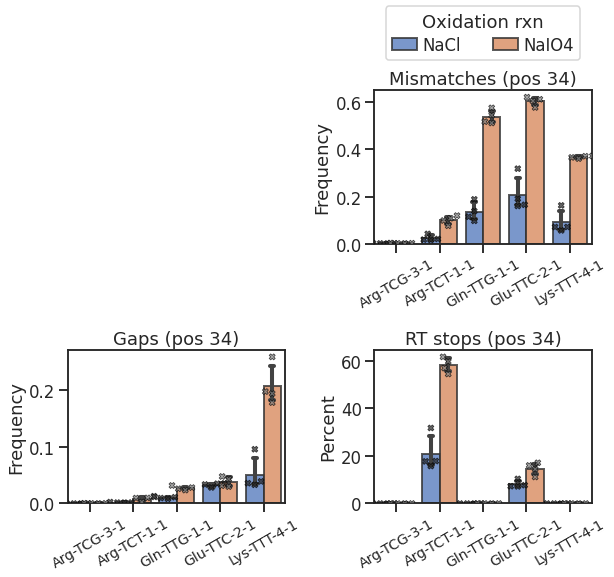

In [15]:
# Plot the mutation/gap/RT stop data for
# position 34 to infer mcm5s2U modification status:
fig = plt.figure(figsize=(9, 8.5))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

x_order = natsorted(set(df_cat['anno_shorter']))
hue_order = ['NaCl', 'NaIO4']

for dtyp, ax in zip(['mut', 'gap', 'RTstops'], [ax1, ax2, ax3]):
    mask = (df_cat['data_type'] == dtyp)
    g1 = sns.barplot(ax=ax, data=df_cat[mask], x='anno_shorter', y='mut_freq', hue='sample_name_ox', \
                     capsize=0.1, edgecolor=".2", linewidth=2, alpha=0.8, \
                     order=x_order, hue_order=hue_order)
    g2 = sns.swarmplot(ax=ax, data=df_cat[mask], x='anno_shorter', y='mut_freq', hue='sample_name_ox', \
                       palette='dark:grey', alpha=0.7, edgecolor='black', dodge=True, \
                       linewidth=0.8, size=6, marker='X', warn_thresh=1, order=x_order, legend=False, \
                       hue_order=hue_order)
    g1.set_xticklabels(g1.get_xticklabels(), rotation=30, size=14)

    if dtyp == 'RTstops':
        g2.set_ylabel('Percent')
        g2.set_xlabel('')
        g2.set_title('RT stops (pos 34)')
        g1.legend_ = None

    if dtyp == 'mut':
        g2.set_ylabel('Frequency')
        g2.set_xlabel('')
        g2.set_title('Mismatches (pos 34)')
        sns.move_legend(g1, "lower center", bbox_to_anchor=(0.5, 1.17), \
                        ncol=2, title='Oxidation rxn', alignment='center', \
                        labelspacing=0.3, handletextpad=0.3, borderaxespad=0.2, \
                        handlelength=1.5)

    if dtyp == 'gap':
        g2.set_ylabel('Frequency')
        g2.set_xlabel('')
        g2.set_title('Gaps (pos 34)')
        g1.legend_ = None

fig.tight_layout()
fig.savefig('data/transcript_mutations/pos34_mcm5s2U_NoOx-vs-Ox.pdf', bbox_inches='tight')